In [ ]:
# Попробовать мягкий OOD -- когда ковариаты отличаются небольшим шумом. Аппроксимация ансамблем будет разумной. # +
# Посмотреть на различные аггрегации -- разные loss functions, все excess риски, bayes риски и тд... # +
# Посмотреть на абсолютные значени рисков. Сравнить их порядки # +
# Посмотреть на корреляции между Excess/Bayes... Посмотреть как часто несоглащаются разные члены ансамбля между собой. # +/-

# Попробовать откалибровать модели
# CIFAR10N / CIFAR10H

In [4]:
import sys
sys.path.insert(0, 'src/')
sys.path.insert(1, 'external_repos/pytorch_cifar100/')
sys.path.insert(1, 'external_repos/pytorch_cifar10/')
import numpy as np
from tqdm.auto import tqdm
from src.postprocessing_utils import (
    get_metrics_results,
    uq_funcs_with_names,
    get_uncertainty_scores,
    get_predicted_labels,
    make_aggregation,
    get_missclassification_dataframe,
    get_ood_detection_dataframe,
    get_raw_scores_dataframe,
    ravel_df,
)
from src.table_utils import pretty_matplotlib_config
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from IPython.display import display
pd.set_option('display.max_rows', None)

In [15]:
architecture = 'resnet18' # vgg resnet18
training_dataset_name = 'cifar10' # 'cifar10' 'cifar100' 'noisy_cifar10' 'noisy_cifar100' 'missed_class_cifar10'
if training_dataset_name not in ['missed_class_cifar10', 'noisy_cifar10', 'noisy_cifar100']:
    dataset_name_to_extract_from = training_dataset_name
else:
    dataset_name_to_extract_from = training_dataset_name.split('_')[-1]
print(dataset_name_to_extract_from)

temperature = 1.

model_ids = np.arange(20)
# model_ids = np.arange(6)

list_extraction_datasets=['cifar10', 'cifar100', 'svhn', 'blurred_cifar100', 'blurred_cifar10']
list_ood_datasets = [el for el in list_extraction_datasets]
loss_function_names = [
    'brier_score',
    'cross_entropy',
    'spherical_score'
]

use_cheating_approximation = False #########
gt_prob_approx = 'same' # same as the predictive prob approximation
# gt_prob_approx = 'flat' # uniform
# gt_prob_approx = 'diracs' # mixture of diracs
# gt_prob_approx = 'random' # random samples

cifar10


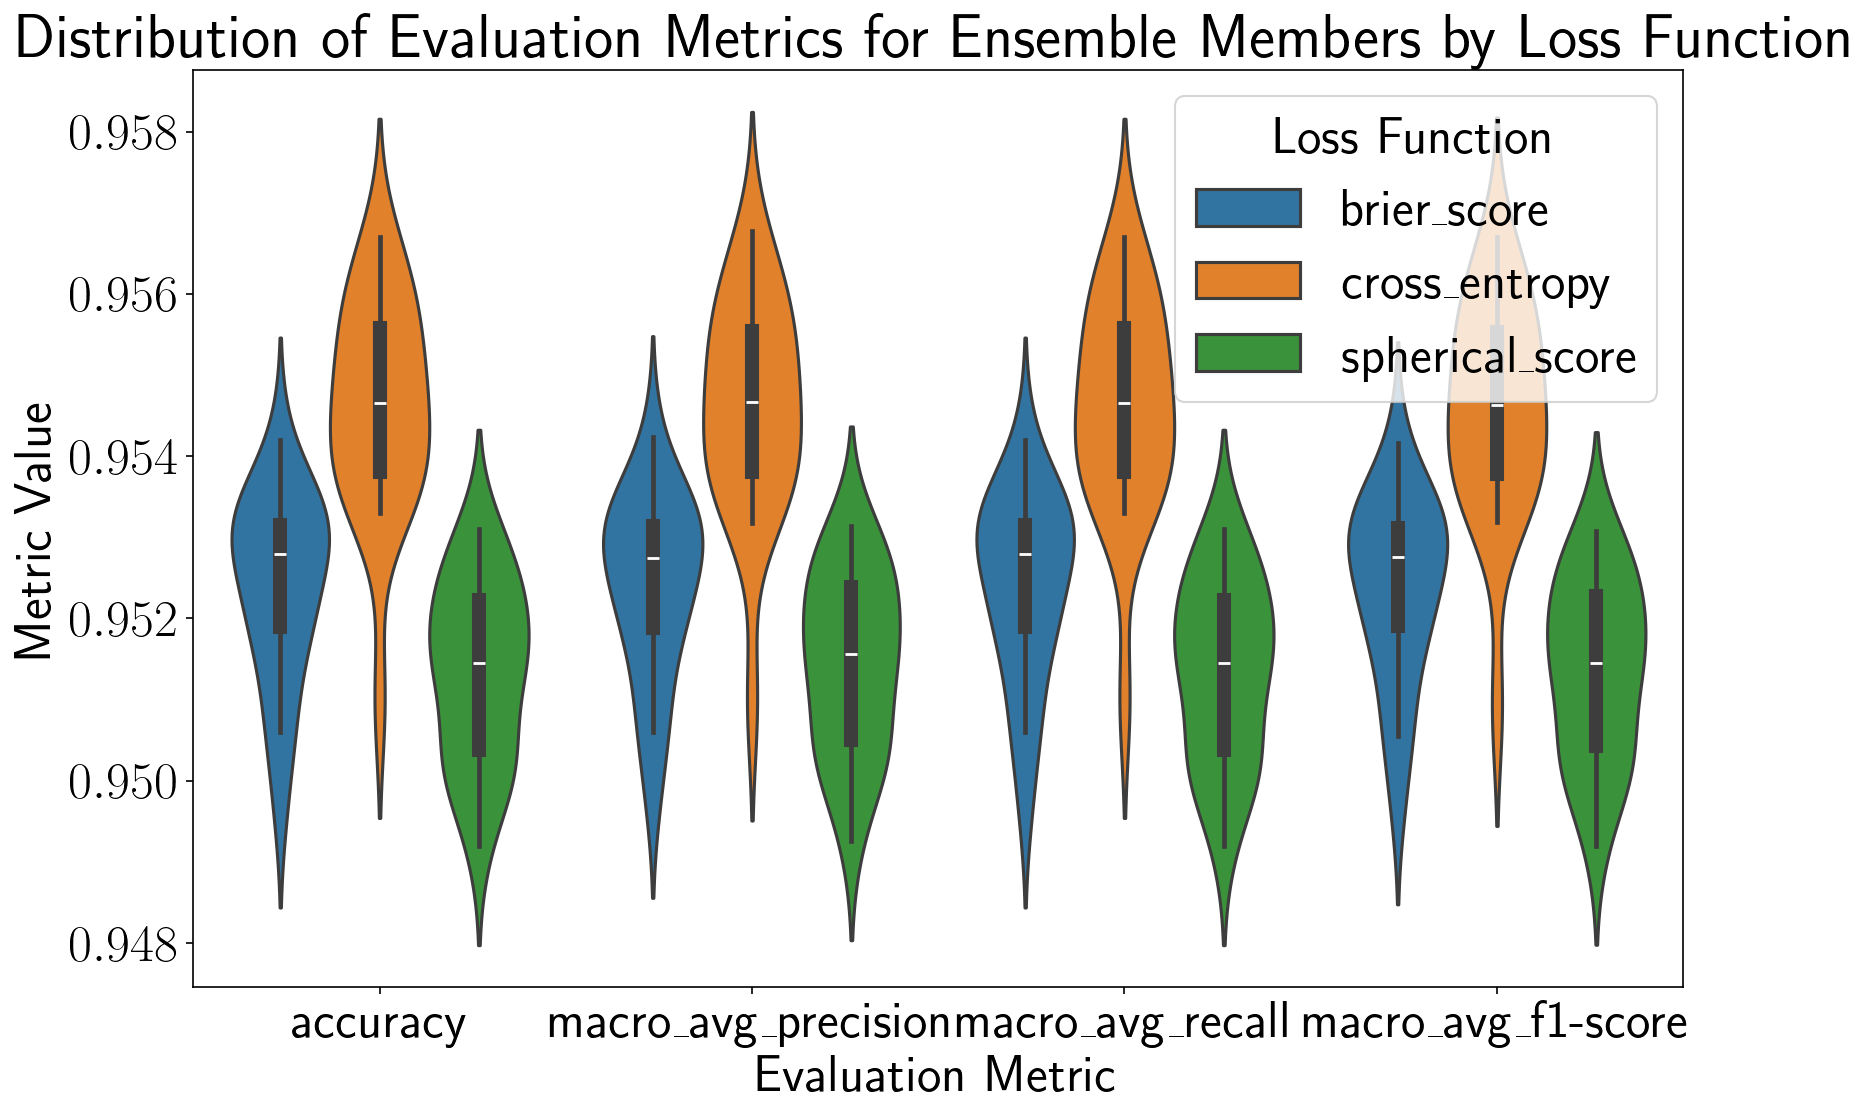

In [20]:
metrics_df = get_metrics_results(
    loss_function_names=loss_function_names,
    training_dataset_name=training_dataset_name,
    architecture=architecture,
    model_ids=model_ids,
)


pretty_matplotlib_config(fontsize=25, fonttype=42)
# Set up the matplotlib figure
plt.figure(figsize=(12, 8), dpi=150)

# Draw a nested violinplot
sns.violinplot(data=metrics_df, x="Metric", y="Value", hue="Loss Function", linewidth=1.5)
plt.title('Distribution of Evaluation Metrics for Ensemble Members by Loss Function')
plt.ylabel('Metric Value')
plt.xlabel('Evaluation Metric')
plt.legend(title='Loss Function')

plt.tight_layout()
plt.savefig(f'imgs/trainstats_{architecture}_{training_dataset_name}.pdf')
plt.show()


In [5]:
uq_results, embeddings_per_dataset, targets_per_dataset = get_uncertainty_scores(
    loss_function_names=loss_function_names,
    training_dataset_name=training_dataset_name,
    architecture=architecture,
    model_ids=model_ids,
    list_extraction_datasets=list_extraction_datasets,
    temperature=temperature,
    use_cheating_approximation=use_cheating_approximation,
    use_cached=True
)

100%|██████████████████████████████████████████████████████████████████| 65/65 [02:16<00:00,  2.10s/it]


In [6]:
max_ind = int(targets_per_dataset[dataset_name_to_extract_from].shape[0] / len(model_ids))
true_labels = targets_per_dataset[dataset_name_to_extract_from][:max_ind]

pred_labels = get_predicted_labels(
    embeddings_per_dataset=embeddings_per_dataset,
    training_dataset_name=dataset_name_to_extract_from,
)

# embeddings_per_dataset_aux = {}
# for dataset_ in embeddings_per_dataset:
#     embeddings_per_dataset_aux[dataset_] = np.vstack([embeddings_per_dataset[dataset_][i_][None] for i_ in model_ids])

# embeddings_per_dataset = embeddings_per_dataset_aux

In [7]:
unique_classes = np.unique(embeddings_per_dataset['cifar100'][1].argmax(-1), return_counts=True)[0]
print(unique_classes)
print(len(unique_classes))

[0 1 2 3 4 5 6 7 8 9]
10


In [8]:
embeddings_per_dataset['cifar100'].shape

(20, 10000, 10)

# OOD Detection

In [9]:
df_ood = get_ood_detection_dataframe(
    ind_dataset=dataset_name_to_extract_from,
    uq_results=uq_results,
    list_ood_datasets=list_ood_datasets,
)

In [10]:
len(df_ood)

975

In [11]:
df_ood[df_ood.Dataset == 'cifar100'].sort_values(by=['RocAucScore'], ascending=False)

,UQMetric,Dataset,LossFunction,RocAucScore
244,Bayes Neglog Inner,cifar100,cross_entropy,0.926211
109,Total Neglog Inner,cifar100,cross_entropy,0.926211
199,Bayes Logscore Outer,cifar100,cross_entropy,0.923182
184,Bayes Logscore Inner,cifar100,cross_entropy,0.921952
94,Total Logscore Inner,cifar100,cross_entropy,0.921952
289,Bayes Spherical Outer,cifar100,cross_entropy,0.921502
169,Bayes Brier Outer,cifar100,cross_entropy,0.921359
243,Bayes Neglog Inner,cifar100,brier_score,0.920662
108,Total Neglog Inner,cifar100,brier_score,0.920662
229,Bayes Maxprob Outer,cifar100,cross_entropy,0.920556


In [12]:
df_ood[df_ood.Dataset == 'cifar10'].sort_values(by=['RocAucScore'], ascending=False)

,UQMetric,Dataset,LossFunction,RocAucScore
227,Bayes Maxprob Outer,cifar10,spherical_score,0.5
512,Excess Spherical Outer Inner,cifar10,spherical_score,0.5
0,Total Brier Outer,cifar10,brier_score,0.5
616,Reverse Bregman Information Logscore,cifar10,cross_entropy,0.5
585,Bregman Information Spherical,cifar10,brier_score,0.5
586,Bregman Information Spherical,cifar10,cross_entropy,0.5
587,Bregman Information Spherical,cifar10,spherical_score,0.5
600,Reverse Bregman Information Brier,cifar10,brier_score,0.5
601,Reverse Bregman Information Brier,cifar10,cross_entropy,0.5
602,Reverse Bregman Information Brier,cifar10,spherical_score,0.5


In [ ]:
df_ood[df_ood.Dataset == 'svhn'].sort_values(by=['RocAucScore'], ascending=False)

In [14]:
df_ood[df_ood.Dataset == 'blurred_cifar100'].sort_values(by=['RocAucScore'], ascending=False)

,UQMetric,Dataset,LossFunction,RocAucScore
39,Total Neglog Outer,blurred_cifar100,brier_score,0.977305
41,Total Neglog Outer,blurred_cifar100,spherical_score,0.977144
730,BiasBI Logscore,blurred_cifar100,cross_entropy,0.975936
25,Total Logscore Outer,blurred_cifar100,cross_entropy,0.974157
475,Excess Logscore Outer Inner,blurred_cifar100,cross_entropy,0.973742
550,Bregman Information Logscore,blurred_cifar100,cross_entropy,0.973742
355,Excess Logscore Outer Outer,blurred_cifar100,cross_entropy,0.973225
250,Bayes Neglog Inner,blurred_cifar100,cross_entropy,0.972941
115,Total Neglog Inner,blurred_cifar100,cross_entropy,0.972941
729,BiasBI Logscore,blurred_cifar100,brier_score,0.972826


In [15]:
df_ood[df_ood.Dataset == 'blurred_cifar10'].sort_values(by=['RocAucScore'], ascending=False)

,UQMetric,Dataset,LossFunction,RocAucScore
418,Excess Neglog Outer Outer,blurred_cifar10,cross_entropy,0.948256
658,Reverse Bregman Information Neglog,blurred_cifar10,cross_entropy,0.947784
403,Excess Neglog Inner Outer,blurred_cifar10,cross_entropy,0.947784
508,Excess Neglog Outer Inner,blurred_cifar10,cross_entropy,0.945917
583,Bregman Information Neglog,blurred_cifar10,cross_entropy,0.945917
43,Total Neglog Outer,blurred_cifar10,cross_entropy,0.945060
507,Excess Neglog Outer Inner,blurred_cifar10,brier_score,0.939888
582,Bregman Information Neglog,blurred_cifar10,brier_score,0.939888
509,Excess Neglog Outer Inner,blurred_cifar10,spherical_score,0.939225
584,Bregman Information Neglog,blurred_cifar10,spherical_score,0.939225


# Misclassification Detection

In [16]:
pred_labels.shape

(10000,)

In [17]:
df_misclassification = get_missclassification_dataframe(
    ind_dataset=dataset_name_to_extract_from,
    # ind_dataset='blurred_cifar10',
    uq_results=uq_results,
    true_labels=true_labels,
    pred_labels=pred_labels,
)

In [18]:
df_misclassification.sort_values(by=['RocAucScore'], ascending=False)

,UQMetric,LossFunction,RocAucScore
117,Bregman Information Spherical,brier_score,0.955743
192,BiasBI Neglog,brier_score,0.955737
180,BiasBI Spherical,brier_score,0.955737
102,Excess Spherical Outer Inner,brier_score,0.955627
177,MVBI Spherical,brier_score,0.955527
87,Excess Spherical Outer Outer,brier_score,0.955487
138,MV Logscore,brier_score,0.955136
174,MV Spherical,brier_score,0.955097
132,Reverse Bregman Information Spherical,brier_score,0.955054
9,Total Maxprob Outer,brier_score,0.955003


# Aggregations

## OOD

### Total

In [19]:
dataset_ood = 'svhn' # svhn cifar10 cifar100 blurred_cifar10 blurred_cifar100

prefix = "Total" # Total Bayes Excess
suffix = None # Inner Outer None
by_loss_function = False # True False

for suffix in ["Inner", "Outer", None]:
    roc_auc_df = make_aggregation(df_=df_ood.copy(), prefix_=prefix, suffix_=suffix,
                                  dataset_=dataset_ood, by_loss_function_=by_loss_function)
    print(f'{prefix} {suffix}')
    display(roc_auc_df.sort_values(by=[('MeanRocAucScore', 'mean')], ascending=False))

mean_values = roc_auc_df[('MeanRocAucScore', 'mean')]
average_mean = mean_values.mean()
std_mean = mean_values.std()
total_averaged_ood = pd.DataFrame({
    'name': ['Total'],
    'mean': [average_mean],
    'std': [std_mean]
})

Total Inner


UQMetric MeanRocAucScore                
                                    mean       std count
3     Total Neglog Inner        0.977301  0.001921     3
1   Total Logscore Inner        0.971887  0.003481     3
4  Total Spherical Inner        0.967083  0.004155     3
0      Total Brier Inner        0.967083  0.004155     3
2    Total Maxprob Inner        0.962886  0.003361     3

Total Outer


UQMetric MeanRocAucScore                
                                    mean       std count
1   Total Logscore Outer        0.969052  0.005035     3
4  Total Spherical Outer        0.965376  0.004467     3
0      Total Brier Outer        0.963777  0.004274     3
2    Total Maxprob Outer        0.963672  0.004003     3
3     Total Neglog Outer        0.957913  0.027221     3

Total None


GeneralizedMetric MeanRocAucScore                
                               mean       std count
1    Total Logscore        0.970470  0.004171     6
3      Total Neglog        0.967607  0.020265     6
4   Total Spherical        0.966230  0.003970     6
0       Total Brier        0.965430  0.004182     6
2     Total Maxprob        0.963279  0.003334     6

In [21]:
prefix = "Excess" # Total Bayes Excess
by_loss_function = False # True False
# suffix = "Outer" # Inner Outer None
# roc_auc_df = make_aggregation(df_=df_ood.copy(), prefix_=prefix, suffix_=suffix, dataset_=dataset_ood, by_loss_function_=by_loss_function)
# roc_auc_df.sort_values(by=[('MeanRocAucScore', 'mean')], ascending=False)

for suffix in ["Inner", "Outer", None]:
    roc_auc_df = make_aggregation(df_=df_ood.copy(), prefix_=prefix, suffix_=suffix, dataset_=dataset_ood, by_loss_function_=by_loss_function)
    print(f'{prefix} {suffix}')
    display(roc_auc_df.sort_values(by=[('MeanRocAucScore', 'mean')], ascending=False))

mean_values = roc_auc_df[('MeanRocAucScore', 'mean')]
average_mean = mean_values.mean()
std_mean = mean_values.std()
excess_averaged_ood = pd.DataFrame({
    'name': ['Excess'],
    'mean': [average_mean],
    'std': [std_mean]
})

Excess Inner


UQMetric MeanRocAucScore                
                                           mean       std count
4  Excess Spherical Outer Inner        0.736006  0.011572     3
2    Excess Maxprob Outer Inner        0.730812  0.006332     3
1   Excess Logscore Outer Inner        0.726087  0.114101     3
0      Excess Brier Outer Inner        0.547462  0.191513     3
3     Excess Neglog Outer Inner        0.175466  0.043433     3

Excess Outer


UQMetric MeanRocAucScore                
                                           mean       std count
9  Excess Spherical Outer Outer        0.717721  0.021136     3
5    Excess Maxprob Outer Outer        0.701471  0.006256     3
3   Excess Logscore Outer Outer        0.698078  0.117860     3
8  Excess Spherical Inner Outer        0.692875  0.031610     3
4    Excess Maxprob Inner Outer        0.683012  0.015825     3
2   Excess Logscore Inner Outer        0.674748  0.122087     3
1      Excess Brier Outer Outer        0.547462  0.191513     3
0      Excess Brier Inner Outer        0.547462  0.191513     3
7     Excess Neglog Outer Outer        0.183022  0.029364     3
6     Excess Neglog Inner Outer        0.182790  0.025567     3

Excess None


GeneralizedMetric MeanRocAucScore                
                                     mean       std count
9  Excess Spherical Outer        0.726863  0.018236     6
5    Excess Maxprob Outer        0.716141  0.017028     6
3   Excess Logscore Outer        0.712083  0.104878     6
8  Excess Spherical Inner        0.692875  0.031610     3
4    Excess Maxprob Inner        0.683012  0.015825     3
2   Excess Logscore Inner        0.674748  0.122087     3
1      Excess Brier Outer        0.547462  0.171295     6
0      Excess Brier Inner        0.547462  0.191513     3
6     Excess Neglog Inner        0.182790  0.025567     3
7     Excess Neglog Outer        0.179244  0.033416     6

In [22]:
prefix = "Bayes" # Total Bayes Excess
# suffix = None # Inner Outer None
by_loss_function = False # True False


for suffix in ["Inner", "Outer", None]:
    roc_auc_df = make_aggregation(df_=df_ood.copy(), prefix_=prefix, suffix_=suffix, dataset_=dataset_ood, by_loss_function_=by_loss_function)
    print(f'{prefix} {suffix}')
    display(roc_auc_df.sort_values(by=[('MeanRocAucScore', 'mean')], ascending=False))

mean_values = roc_auc_df[('MeanRocAucScore', 'mean')]
average_mean = mean_values.mean()
std_mean = mean_values.std()
bayes_averaged_ood = pd.DataFrame({
    'name': ['Bayes'],
    'mean': [average_mean],
    'std': [std_mean]
})

Bayes Inner


UQMetric MeanRocAucScore                
                                    mean       std count
3     Bayes Neglog Inner        0.893538  0.016392     3
1   Bayes Logscore Inner        0.880668  0.009627     3
4  Bayes Spherical Inner        0.868457  0.007506     3
0      Bayes Brier Inner        0.868457  0.007506     3
2    Bayes Maxprob Inner        0.859634  0.007930     3

Bayes Outer


UQMetric MeanRocAucScore                
                                    mean       std count
3     Bayes Neglog Outer        0.889431  0.017502     3
1   Bayes Logscore Outer        0.881647  0.011996     3
4  Bayes Spherical Outer        0.874838  0.008510     3
0      Bayes Brier Outer        0.873810  0.007738     3
2    Bayes Maxprob Outer        0.871422  0.007540     3

Bayes None


GeneralizedMetric MeanRocAucScore                
                               mean       std count
3      Bayes Neglog        0.891485  0.015332     6
1    Bayes Logscore        0.881158  0.009743     6
4   Bayes Spherical        0.871647  0.007983     6
0       Bayes Brier        0.871133  0.007422     6
2     Bayes Maxprob        0.865528  0.009465     6

In [23]:
prefix = "Bregman Information" # Total Bayes Excess
suffix = None # Inner Outer None
by_loss_function = False # True False
roc_auc_df = make_aggregation(df_=df_ood.copy(), prefix_=prefix, suffix_=suffix, dataset_=dataset_ood, by_loss_function_=by_loss_function)
display(roc_auc_df.sort_values(by=[('MeanRocAucScore', 'mean')], ascending=False))

mean_values = roc_auc_df[('MeanRocAucScore', 'mean')]
average_mean = mean_values.mean()
std_mean = mean_values.std()
bregman_averaged_ood = pd.DataFrame({
    'name': ['Bregman'],
    'mean': [average_mean],
    'std': [std_mean]
})

GeneralizedMetric MeanRocAucScore                
                                            mean       std count
4  Bregman Information Spherical        0.736006  0.011573     3
2    Bregman Information Maxprob        0.730961  0.006412     3
1   Bregman Information Logscore        0.726087  0.114101     3
0      Bregman Information Brier        0.547462  0.191513     3
3     Bregman Information Neglog        0.175466  0.043434     3

In [24]:
prefix = "Reverse Bregman Information" # Total Bayes Excess
suffix = None # Inner Outer None
by_loss_function = False # True False
roc_auc_df = make_aggregation(df_=df_ood.copy(), prefix_=prefix, suffix_=suffix, dataset_=dataset_ood, by_loss_function_=by_loss_function)
display(roc_auc_df.sort_values(by=[('MeanRocAucScore', 'mean')], ascending=False))

mean_values = roc_auc_df[('MeanRocAucScore', 'mean')]
average_mean = mean_values.mean()
std_mean = mean_values.std()
reverse_bregman_averaged_ood = pd.DataFrame({
    'name': ['Reverse Bregman'],
    'mean': [average_mean],
    'std': [std_mean]
})

GeneralizedMetric MeanRocAucScore                
                                                    mean       std count
4  Reverse Bregman Information Spherical        0.692874  0.031609     3
2    Reverse Bregman Information Maxprob        0.682955  0.015829     3
1   Reverse Bregman Information Logscore        0.674748  0.122087     3
0      Reverse Bregman Information Brier        0.547462  0.191514     3
3     Reverse Bregman Information Neglog        0.182790  0.025567     3

In [25]:
average_df_ood = pd.concat([
    total_averaged_ood,
    excess_averaged_ood,
    bayes_averaged_ood,
    bregman_averaged_ood,
    reverse_bregman_averaged_ood
])
average_df_ood.sort_values(by=['mean'], ascending=False)

,name,mean,std
0,Bayes,0.876190,0.010228
0,Total,0.835353,0.068694
0,Bregman,0.583196,0.241415
0,Excess,0.566268,0.213044
0,Reverse Bregman,0.556166,0.216974


## Misclassification

In [26]:
prefix = "Total" # Total Bayes Excess
suffix = None # Inner Outer None
by_loss_function = False

for suffix in ["Inner", "Outer", None]:
    roc_auc_df = make_aggregation(df_=df_misclassification.copy(), prefix_=prefix, suffix_=suffix,
                                  dataset_=None, by_loss_function_=by_loss_function)
    print(f'{prefix} {suffix}')
    display(roc_auc_df.sort_values(by=[('MeanRocAucScore', 'mean')], ascending=False))

mean_values = roc_auc_df[('MeanRocAucScore', 'mean')]
average_mean = mean_values.mean()
std_mean = mean_values.std()
total_averaged_miss = pd.DataFrame({
    'name': ['Total'],
    'mean': [average_mean],
    'std': [std_mean]
})

Total Inner


UQMetric MeanRocAucScore          
                                    mean std count
4  Total Spherical Inner        0.921677 NaN     1
0      Total Brier Inner        0.921676 NaN     1
2    Total Maxprob Inner        0.921657 NaN     1
1   Total Logscore Inner        0.918993 NaN     1
3     Total Neglog Inner        0.900469 NaN     1

Total Outer


UQMetric MeanRocAucScore          
                                    mean std count
2    Total Maxprob Outer        0.914421 NaN     1
4  Total Spherical Outer        0.909936 NaN     1
0      Total Brier Outer        0.908728 NaN     1
1   Total Logscore Outer        0.822087 NaN     1
3     Total Neglog Outer        0.667765 NaN     1

Total None


GeneralizedMetric MeanRocAucScore                
                               mean       std count
2     Total Maxprob        0.918039  0.005117     2
4   Total Spherical        0.915806  0.008302     2
0       Total Brier        0.915202  0.009156     2
1    Total Logscore        0.870540  0.068522     2
3      Total Neglog        0.784117  0.164546     2

In [27]:
prefix = "Excess" # Total Bayes Excess
suffix = None # Inner Outer None
by_loss_function = False

for suffix in ["Inner", "Outer", None]:
    roc_auc_df = make_aggregation(df_=df_misclassification.copy(), prefix_=prefix, suffix_=suffix,
                                  dataset_=None, by_loss_function_=by_loss_function)
    print(f'{prefix} {suffix}')
    display(roc_auc_df.sort_values(by=[('MeanRocAucScore', 'mean')], ascending=False))

mean_values = roc_auc_df[('MeanRocAucScore', 'mean')]
average_mean = mean_values.mean()
std_mean = mean_values.std()
excess_averaged_miss = pd.DataFrame({
    'name': ['Excess'],
    'mean': [average_mean],
    'std': [std_mean]
})

Excess Inner


UQMetric MeanRocAucScore          
                                           mean std count
4  Excess Spherical Outer Inner        0.879340 NaN     1
0      Excess Brier Outer Inner        0.870728 NaN     1
2    Excess Maxprob Outer Inner        0.852392 NaN     1
1   Excess Logscore Outer Inner        0.839455 NaN     1
3     Excess Neglog Outer Inner        0.664093 NaN     1

Excess Outer


UQMetric MeanRocAucScore          
                                           mean std count
9  Excess Spherical Outer Outer        0.878756 NaN     1
8  Excess Spherical Inner Outer        0.871749 NaN     1
0      Excess Brier Inner Outer        0.870728 NaN     1
1      Excess Brier Outer Outer        0.870728 NaN     1
5    Excess Maxprob Outer Outer        0.863677 NaN     1
4    Excess Maxprob Inner Outer        0.799295 NaN     1
3   Excess Logscore Outer Outer        0.733613 NaN     1
2   Excess Logscore Inner Outer        0.709780 NaN     1
6     Excess Neglog Inner Outer        0.662714 NaN     1
7     Excess Neglog Outer Outer        0.661830 NaN     1

Excess None


GeneralizedMetric MeanRocAucScore                    
                                     mean           std count
9  Excess Spherical Outer        0.879048  4.127796e-04     2
8  Excess Spherical Inner        0.871749           NaN     1
0      Excess Brier Inner        0.870728           NaN     1
1      Excess Brier Outer        0.870728  2.082117e-07     2
5    Excess Maxprob Outer        0.858034  7.979712e-03     2
4    Excess Maxprob Inner        0.799295           NaN     1
3   Excess Logscore Outer        0.786534  7.484210e-02     2
2   Excess Logscore Inner        0.709780           NaN     1
7     Excess Neglog Outer        0.662961  1.600002e-03     2
6     Excess Neglog Inner        0.662714           NaN     1

In [28]:
prefix = "Bayes" # Total Bayes Excess
suffix = None # Inner Outer None
by_loss_function = False

for suffix in ["Inner", "Outer", None]:
    roc_auc_df = make_aggregation(df_=df_misclassification.copy(), prefix_=prefix, suffix_=suffix,
                                  dataset_=None, by_loss_function_=by_loss_function)
    print(f'{prefix} {suffix}')
    display(roc_auc_df.sort_values(by=[('MeanRocAucScore', 'mean')], ascending=False))

mean_values = roc_auc_df[('MeanRocAucScore', 'mean')]
average_mean = mean_values.mean()
std_mean = mean_values.std()
bayes_averaged_miss = pd.DataFrame({
    'name': ['Bayes'],
    'mean': [average_mean],
    'std': [std_mean]
})

Bayes Inner


UQMetric MeanRocAucScore          
                                    mean std count
4  Bayes Spherical Inner        0.921677 NaN     1
0      Bayes Brier Inner        0.921676 NaN     1
2    Bayes Maxprob Inner        0.921657 NaN     1
1   Bayes Logscore Inner        0.918993 NaN     1
3     Bayes Neglog Inner        0.900469 NaN     1

Bayes Outer


UQMetric MeanRocAucScore          
                                    mean std count
0      Bayes Brier Outer        0.942796 NaN     1
1   Bayes Logscore Outer        0.942087 NaN     1
4  Bayes Spherical Outer        0.941996 NaN     1
2    Bayes Maxprob Outer        0.941443 NaN     1
3     Bayes Neglog Outer        0.934110 NaN     1

Bayes None


GeneralizedMetric MeanRocAucScore                
                               mean       std count
0       Bayes Brier        0.932236  0.014934     2
4   Bayes Spherical        0.931836  0.014368     2
2     Bayes Maxprob        0.931550  0.013991     2
1    Bayes Logscore        0.930540  0.016330     2
3      Bayes Neglog        0.917289  0.023788     2

In [29]:
prefix = "Bregman Information" # Total Bayes Excess
suffix = None # Inner Outer None
by_loss_function = False # True False
roc_auc_df = make_aggregation(df_=df_misclassification.copy(), prefix_=prefix, suffix_=suffix,
                              dataset_=None, by_loss_function_=by_loss_function)
display(roc_auc_df.sort_values(by=[('MeanRocAucScore', 'mean')], ascending=False))

mean_values = roc_auc_df[('MeanRocAucScore', 'mean')]
average_mean = mean_values.mean()
std_mean = mean_values.std()
bregman_averaged_miss = pd.DataFrame({
    'name': ['Bregman Information'],
    'mean': [average_mean],
    'std': [std_mean]
})

GeneralizedMetric MeanRocAucScore          
                                            mean std count
4  Bregman Information Spherical        0.879797 NaN     1
0      Bregman Information Brier        0.870728 NaN     1
2    Bregman Information Maxprob        0.854104 NaN     1
1   Bregman Information Logscore        0.839457 NaN     1
3     Bregman Information Neglog        0.664090 NaN     1

In [30]:
prefix = "Reverse Bregman Information" # Total Bayes Excess
suffix = None # Inner Outer None
by_loss_function = False # True False
roc_auc_df = make_aggregation(df_=df_misclassification.copy(), prefix_=prefix, suffix_=suffix,
                              dataset_=None, by_loss_function_=by_loss_function)
display(roc_auc_df.sort_values(by=[('MeanRocAucScore', 'mean')], ascending=False))

mean_values = roc_auc_df[('MeanRocAucScore', 'mean')]
average_mean = mean_values.mean()
std_mean = mean_values.std()
reverse_bregman_averaged_miss = pd.DataFrame({
    'name': ['Reverse Bregman Information'],
    'mean': [average_mean],
    'std': [std_mean]
})

GeneralizedMetric MeanRocAucScore          
                                                    mean std count
4  Reverse Bregman Information Spherical        0.872360 NaN     1
0      Reverse Bregman Information Brier        0.871189 NaN     1
2    Reverse Bregman Information Maxprob        0.801818 NaN     1
1   Reverse Bregman Information Logscore        0.709784 NaN     1
3     Reverse Bregman Information Neglog        0.662714 NaN     1

In [31]:
average_df_miss = pd.concat([
    total_averaged_miss,
    excess_averaged_miss,
    bayes_averaged_miss,
    bregman_averaged_miss,
    reverse_bregman_averaged_miss
])
average_df_miss.sort_values(by=['mean'], ascending=False)

,name,mean,std
0,Bayes,0.928690,0.006404
0,Total,0.880741,0.057551
0,Bregman Information,0.821635,0.089422
0,Excess,0.797157,0.088592
0,Reverse Bregman Information,0.783573,0.094795


### Correlations

In [67]:
scores_df_unravel = get_raw_scores_dataframe(uq_results=uq_results)

In [68]:
dataset_name_to_extract_from

'cifar10'

In [69]:
score = "Neglog"

cond1 = scores_df_unravel['UQ Method'] == f'Excess {score} Inner Outer'
cond2 = scores_df_unravel['Dataset'] == dataset_name_to_extract_from
rbi = scores_df_unravel.where(cond1 & cond2).dropna()['Scores'].values[0]

cond1 = scores_df_unravel['UQ Method'] == f'Bregman Information {score}'
bi = scores_df_unravel.where(cond1 & cond2).dropna()['Scores'].values[0]

cond1 = scores_df_unravel['UQ Method'] == f'Excess {score} Outer Outer'
epbd = scores_df_unravel.where(cond1 & cond2).dropna()['Scores'].values[0]

In [70]:
epbd.shape

(10000,)

In [71]:
bi.shape

(10000,)

In [72]:
rbi.shape

(10000,)

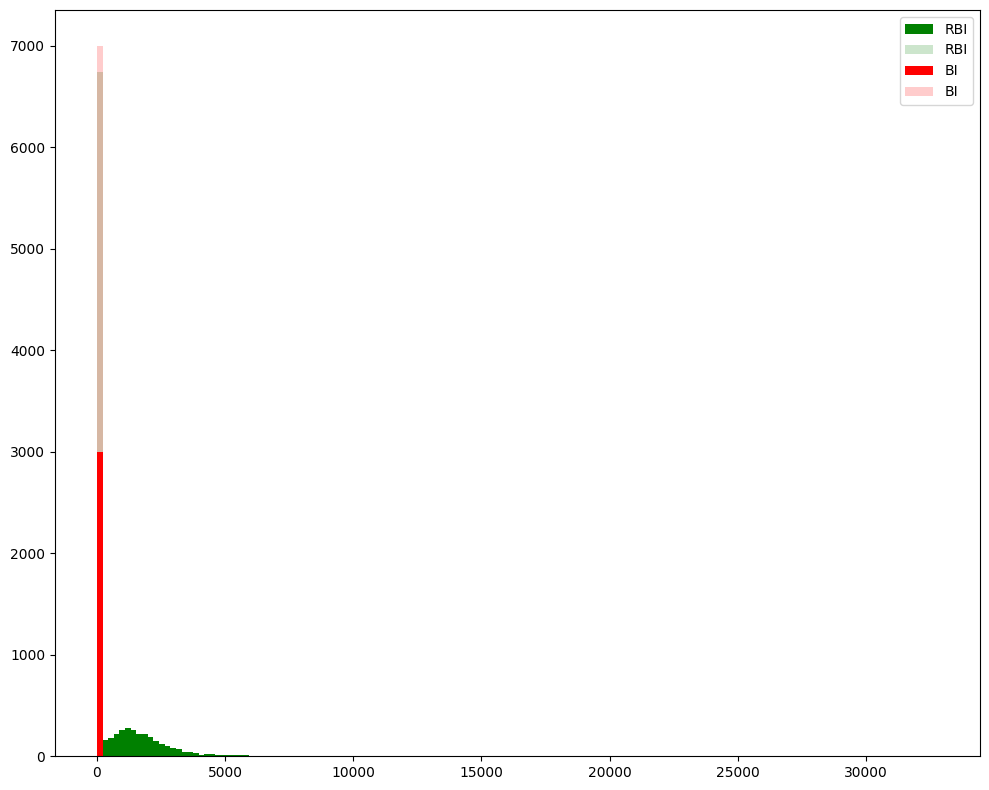

In [76]:
plt.figure(figsize=(10, 8))

n_bins = 150
max_ = np.hstack([epbd, bi, rbi]).max()
min_ = np.hstack([epbd, bi, rbi]).min()
bins = np.linspace(min_, max_, n_bins)

missed_labels_mask = np.isin(true_labels, [0, 1, 2])


# plt.hist(epbd[missed_labels_mask], bins=bins, label='EPBD', color='blue', alpha=1.)
# plt.hist(epbd[~missed_labels_mask], bins=bins, label='EPBD', color='blue', alpha=0.2)

plt.hist(rbi[missed_labels_mask], bins=bins, label='RBI', color='green', alpha=1.)
plt.hist(rbi[~missed_labels_mask], bins=bins, label='RBI', color='green', alpha=0.2)

plt.hist(bi[missed_labels_mask], bins=bins, label='BI', color='red', alpha=1.)
plt.hist(bi[~missed_labels_mask], bins=bins, label='BI', color='red', alpha=0.2)

plt.legend()
plt.tight_layout()
plt.show()

In [77]:
from sklearn.metrics import roc_auc_score

y_true = np.hstack([
    np.ones(len(rbi[missed_labels_mask])),
    np.zeros(len(rbi[~missed_labels_mask]))
])

In [78]:
y_true = np.hstack([
    np.ones(len(bi[missed_labels_mask])),
    np.zeros(len(bi[~missed_labels_mask]))
])

scores_bi = np.hstack([bi[missed_labels_mask], bi[~missed_labels_mask]])
scores_rbi = np.hstack([rbi[missed_labels_mask], rbi[~missed_labels_mask]])
scores_epbd = np.hstack([epbd[missed_labels_mask], epbd[~missed_labels_mask]])

print('BI: ', roc_auc_score(y_true, scores_bi))
print('RBI', roc_auc_score(y_true, scores_rbi))
print('EPBD', roc_auc_score(y_true, scores_epbd))

BI:  0.9496535000000002
RBI 0.9919236666666668
EPBD 0.991917380952381


In [43]:
from src.uncertainty_scores import bi_logscore, excess_logscore_inner, excess_logscore_outer

In [36]:
eps = 1e-5
probs_1 = np.array([
    [eps, (1 - eps) / 2, (1 - eps) / 2],
    [eps, 1 - 2 * eps, eps],
    [eps, eps, 1 - 2 * eps],
    [2 * eps, (1 - 2 * eps) / 2, (1 - 2 * eps) / 2],
    [4 * eps, (1 - 4 * eps) / 2, (1 - 4 * eps) / 2],
    [6 * eps, (1 - 6 * eps) / 2, (1 - 6 * eps) / 2],
    [8 * eps, (1 - 8 * eps) / 2, (1 - 8 * eps) / 2],
    [1 - 2 * eps, eps, eps],
])[:, None, :]

mi_ex = bi_logscore(logits_gt=np.log(probs_1), logits_pred=np.log(probs_1))
rmi_ex = excess_logscore_inner(logits_gt=np.log(probs_1), logits_pred=np.log(probs_1))
epkl_ex = excess_logscore_outer(logits_gt=np.log(probs_1), logits_pred=np.log(probs_1))

print(mi_ex, rmi_ex, epkl_ex)

[0.54972862] [3.08064137] [3.63036999]


In [37]:
eps = 1e-5
probs_2 = np.array([
    [1 - 4 * eps, 3 * eps, eps],
    [1 - 2 * eps, eps, eps],
    [1 - 3 * eps, 2 * eps, eps],
    [1 - 4 * eps, 2 * eps, 2 * eps],
    [1 - 2 * eps, eps, eps],
    [1 - 6 * eps, 2 * eps, 4 * eps],
    [1 - 6 * eps, 4 * eps, 2 * eps],
    [eps, (1 - eps) / 2, (1 - eps) / 2],
    # [eps, 1 - 2 * eps, eps],
    # [eps, eps, 1 - 2 * eps],
])[:, None, :]

mi_ex = bi_logscore(logits_gt=np.log(probs_2), logits_pred=np.log(probs_2))
rmi_ex = excess_logscore_inner(logits_gt=np.log(probs_2), logits_pred=np.log(probs_2))
epkl_ex = excess_logscore_outer(logits_gt=np.log(probs_2), logits_pred=np.log(probs_2))

print(mi_ex, rmi_ex, epkl_ex)

[0.37644549] [2.00876153] [2.38520702]


# Comparison of different risk components

In [28]:
import seaborn as sns

,Total,Excess outer,Bayes outer,Excess inner,Bayes inner,Bregman Information,Total outer,Total inner
count,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000
mean,0.077806,4.089325e-02,0.036913,0.015445,0.062361,2.544831e-02,0.077806,0.077806
std,0.154505,1.021255e-01,0.057342,0.036215,0.123936,7.253328e-02,0.154505,0.154505
min,0.002515,-1.773238e-08,0.002515,0.000000,0.002515,-1.773238e-08,0.002515,0.002515
25%,0.010499,0.000000e+00,0.010499,0.000000,0.010499,0.000000e+00,0.010499,0.010499
50%,0.013242,0.000000e+00,0.013242,0.000000,0.013242,0.000000e+00,0.013242,0.013242
75%,0.027552,0.000000e+00,0.026674,0.000000,0.027552,0.000000e+00,0.027552,0.027552
max,0.852040,5.467819e-01,0.500985,0.198054,0.808844,5.059299e-01,0.852040,0.852040


,Total,Excess outer,Bayes outer,Excess inner,Bayes inner,Bregman Information,Total outer,Total inner
Total,1.000000,0.982746,0.944187,0.877809,0.990156,0.945412,1.000000,1.000000
Excess outer,0.982746,1.000000,0.866968,0.876050,0.969160,0.970584,0.982746,0.982746
Bayes outer,0.944187,0.866968,1.000000,0.804975,0.941859,0.818764,0.944187,0.944187
Excess inner,0.877809,0.876050,0.804975,1.000000,0.802122,0.734178,0.877809,0.877809
Bayes inner,0.990156,0.969160,0.941859,0.802122,1.000000,0.964073,0.990156,0.990156
Bregman Information,0.945412,0.970584,0.818764,0.734178,0.964073,1.000000,0.945412,0.945412
Total outer,1.000000,0.982746,0.944187,0.877809,0.990156,0.945412,1.000000,1.000000
Total inner,1.000000,0.982746,0.944187,0.877809,0.990156,0.945412,1.000000,1.000000


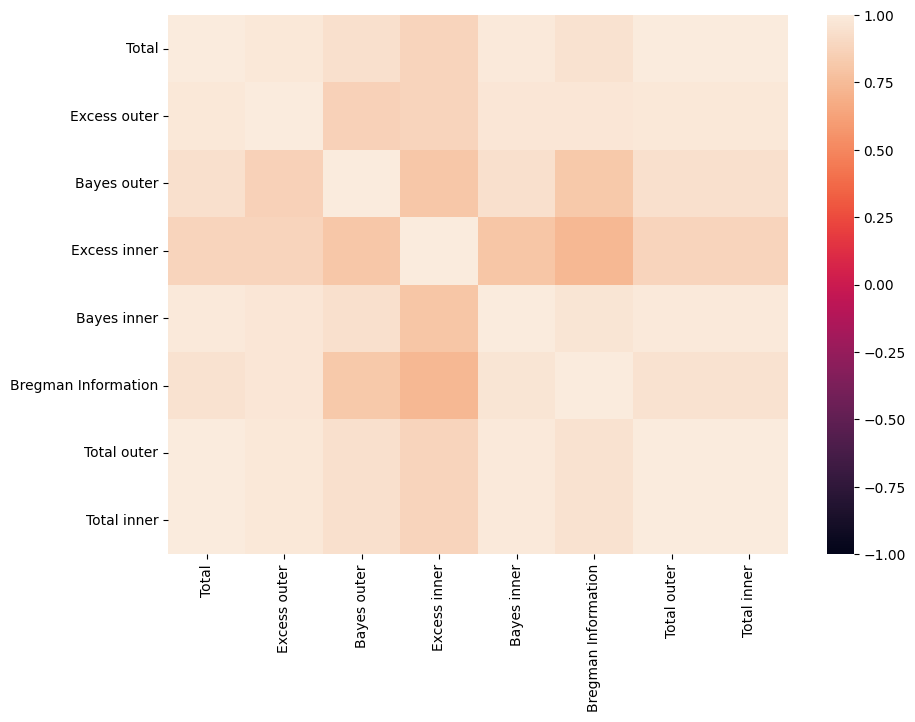

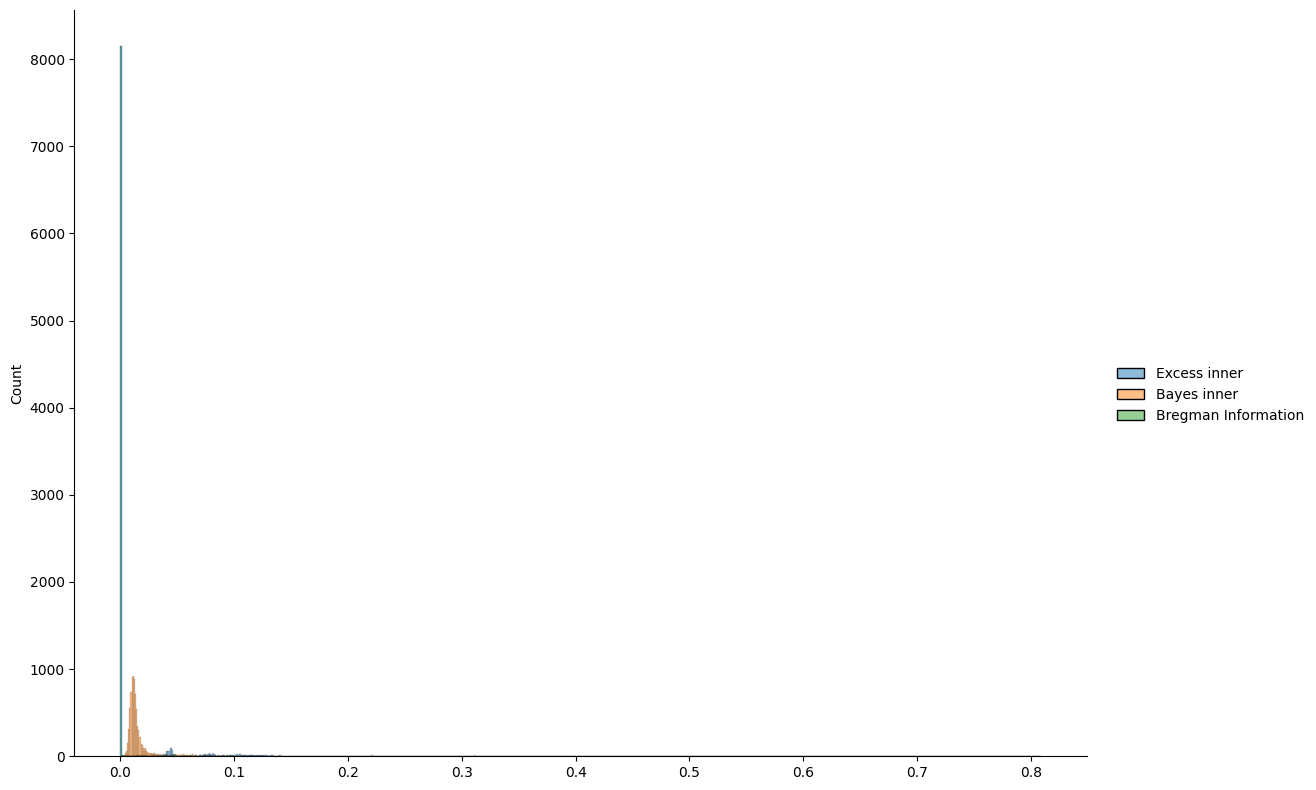

In [29]:
loss_function = 'brier_score' # cross_entropy brier_score spherical_score
dataset = 'cifar10' # svhn cifar10 cifar100 blurred_cifar10 blurred_cifar100
score = 'Maxprob' # Logscore Brier Neglog Maxprob Spherical

plt.figure(figsize=(10, 7))

scores_df = ravel_df(
    df=scores_df_unravel,
    loss_function=loss_function,
    dataset=dataset,
    score=score,
)

display(scores_df.describe())
display(scores_df.corr())

sns.heatmap(scores_df.corr(), vmin=-1, vmax=1)

sns.displot(
    scores_df[
    [
        # "Total",

        # "Excess outer",
        # "Bayes outer",

        "Excess inner",
        "Bayes inner",

        "Bregman Information"
    ]
    ],
    height=8,
    aspect=1.4);

,Total,Excess outer,Bayes outer,Excess inner,Bayes inner,Bregman Information,Total outer,Total inner
count,26032.000000,2.603200e+04,26032.000000,26032.000000,26032.000000,2.603200e+04,26032.000000,26032.000000
mean,0.422640,2.595857e-01,0.163054,0.083987,0.338653,1.755990e-01,0.422640,0.422640
std,0.207025,1.515867e-01,0.079016,0.047324,0.184409,1.311986e-01,0.207025,0.207025
min,0.006808,-3.099441e-08,0.006808,0.000000,0.006808,-3.099441e-08,0.006808,0.006808
25%,0.256738,1.315372e-01,0.105508,0.044312,0.179957,5.135171e-02,0.256738,0.256738
50%,0.467660,2.935258e-01,0.156343,0.089551,0.344401,1.668933e-01,0.467660,0.467660
75%,0.587620,3.822461e-01,0.213248,0.120233,0.490148,2.844961e-01,0.587620,0.587620
max,0.880492,6.030277e-01,0.530821,0.219784,0.822363,5.644215e-01,0.880492,0.880492


,Total,Excess outer,Bayes outer,Excess inner,Bayes inner,Bregman Information,Total outer,Total inner
Total,1.000000,0.949493,0.798509,0.566094,0.977368,0.892851,1.000000,1.000000
Excess outer,0.949493,1.000000,0.569284,0.557943,0.922759,0.954147,0.949493,0.949493
Bayes outer,0.798509,0.569284,1.000000,0.412817,0.790500,0.508845,0.798509,0.798509
Excess inner,0.566094,0.557943,0.412817,1.000000,0.378896,0.283943,0.566094,0.566094
Bayes inner,0.977368,0.922759,0.790500,0.378896,1.000000,0.929485,0.977368,0.977368
Bregman Information,0.892851,0.954147,0.508845,0.283943,0.929485,1.000000,0.892851,0.892851
Total outer,1.000000,0.949493,0.798509,0.566094,0.977368,0.892851,1.000000,1.000000
Total inner,1.000000,0.949493,0.798509,0.566094,0.977368,0.892851,1.000000,1.000000


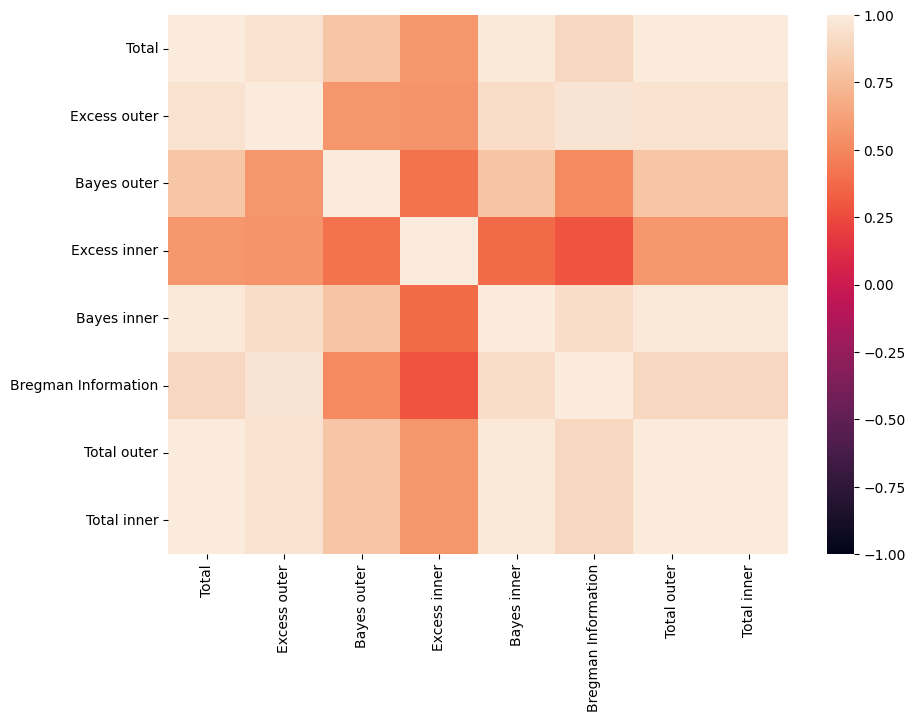

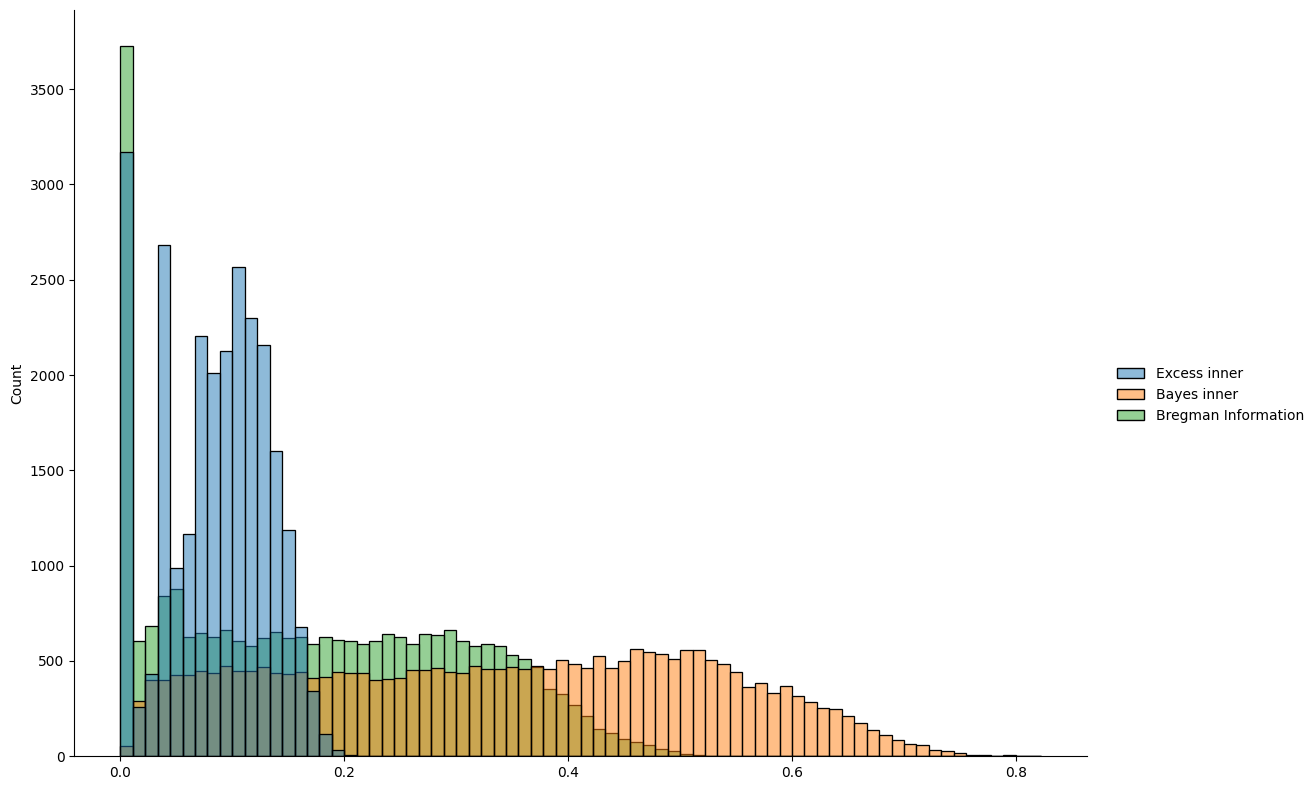

In [30]:
loss_function = 'brier_score' # cross_entropy brier_score spherical_score
dataset = 'svhn' # svhn cifar10 cifar100 blurred_cifar10 blurred_cifar100
score = 'Maxprob' # Logscore Brier Neglog Maxprob Spherical

plt.figure(figsize=(10, 7))

scores_df = ravel_df(
    df=scores_df_unravel,
    loss_function=loss_function,
    dataset=dataset,
    score=score,
)

display(scores_df.describe())
display(scores_df.corr())

sns.heatmap(scores_df.corr(), vmin=-1, vmax=1)

sns.displot(
    scores_df[
    [
        # "Total",

        # "Excess outer",
        # "Bayes outer",

        "Excess inner",
        "Bayes inner",

        "Bregman Information"
    ]
    ],
    height=8,
    aspect=1.4);